# Two-pool model from Barker *et al.* (2020)

In [1]:
pwd()

"/home/kkganko/6.337/18.337-Project-SP2023/Stochastic Diffeqs"

In [2]:
dir_contents = readdir(".")

14-element Vector{String}:
 ".ipynb_checkpoints"
 "Birth-Death.ipynb"
 "BirthDeathFlux.ipynb"
 "Fitting Data to SDE Practice.ipynb"
 "Lux Tutorial.ipynb"
 "MWE Birth-Death-KG.ipynb"
 "MWE Birth-Death.ipynb"
 "MWE Two-Pool-KG.ipynb"
 "Manifest.toml"
 "NN_sde_combined.png"
 "Neural ODE Practice.ipynb"
 "Neural SDE Practice.ipynb"
 "Project.toml"
 "Stochastic Diffeq Practice.ipynb"

In [3]:
dir_contents_parent = readdir("..")

12-element Vector{String}:
 ".git"
 ".gitignore"
 ".ipynb_checkpoints"
 "LICENSE"
 "Manifest.toml"
 "Min working example.ipynb"
 "Project.toml"
 "README.md"
 "Stochastic Diffeqs"
 "generate-project-toml.ipynb"
 "test_lux-componentarrays.ipynb"
 "test_python.ipynb"

In [4]:
# # If Project.toml and Manifest.toml exist, remove them to start a completely fresh installation of packages and dependencies.
# # This is equivalent to uninstalling all packages in the current environment. 
# # Why? B/c if you don't start from a clean plate, and you have previous package dependency installation that were unspecified 
# # below in their version number, then dependencies may conflict.

# # get contents of working directory
# dir_contents = readdir(".")
# println(dir_contents)
# if "Manifest.toml" in dir_contents
#     rm("Manifest.toml")
#     println("Removed Manifest.toml from $(pwd()).")
# end
# if "Project.toml" in dir_contents
#     rm("Project.toml")
#     println("Removed Project.toml from $(pwd()).")
# end

# # Check file contents in project directory, copy over Project.toml and Manifest.toml if they exist.
# # If they don't exist, create them with generate-project-toml.ipynb.
# parentdir_contents = readdir("..")
# parentdir_info = stat("..")
# # copy contents from parent to working directory 
# if "Manifest.toml" in parentdir_contents
#     cp("../Manifest.toml", joinpath(pwd(),"Manifest.toml"))
#     println("Manifest.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Manifest.toml in parent directory.")
# end
# if "Project.toml" in parentdir_contents
#     cp("../Project.toml", joinpath(pwd(),"Project.toml"))
#     println("Project.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Project.toml in parent directory.")
# end

In [5]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [6]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [7]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools 

# Define SDE model

In [8]:
# set up problem: initial conditions, params, solver hyperparams
datasize = 201
tspan = (0.0, 10.0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float64,2,4)

2×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [9]:
# new implementation that can handle Dual numbers for autodiff, i.e., with ForwardDiff.Dual
# some algs tested below require this functionality: ImplicitEulerHeun especially
function trueSDEfunc!(
        du::Vector{T1},
        u::Vector{T2},
        p::Vector{T3},
        t::Float64
) where {T1<:Union{ForwardDiff.Dual,Float64},T2<:Union{ForwardDiff.Dual,Float64},T3<:Union{ForwardDiff.Dual,Float64}}
    
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

# new implementation that can't handle Dual numbers for autodiff...
function true_noise_func!(
        du::Matrix{T1},
        u::Vector{T2},
        p::Vector{T3},
        t::Float64
) where {T1<:Union{ForwardDiff.Dual,Float64},T2<:Union{ForwardDiff.Dual,Float64},T3<:Union{ForwardDiff.Dual,Float64}}
    
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# callbacks
# terminate_condition(u,t,integrator) = (u[1] < 0.0) || (u[2] < 0.0)
# affect_solver!(integrator) = terminate!(integrator, ReturnCode.Terminated) # can't use symbols for retcodes anymore, need to reference directly from ReturnCode object
# cb_stop_solver = DiscreteCallback(terminate_condition,affect_solver!)
# cbs = CallbackSet(cb_stop_solver)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end

condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

u_0 = Float64[
    100.0,
    0.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# put an integer-valued seed to reproduce behavior
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs,
    seed=1
)

println("New implementation EM:")
b1 = @benchmark sol1 = solve(prob_truesde, EM(), dt = 0.05, save_everystep=false)
display(b1)

println("LambaEM w/ guess on initial dt:")
b3 = @benchmark sol3 = solve(prob_truesde, LambaEM(), dt=0.05, save_everystep=false)
display(b3)

New implementation EM:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.500 μs …  35.663 ms  ┊ GC (min … max): 0.00% … 96.24%
 Time  (median):     63.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   70.456 μs ± 356.381 μs  ┊ GC (mean ± σ):  4.87% ±  0.96%

  ▃▆█▇▆▆▇▇▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁ ▁                                   ▂
  ██████████████████████████▇██▇▇▇▆▆▇▇▇▇▇▇▇▇▇█▆▆▇▇▇▇▇▇▄▄▅▅▆▅▄▆ █
  55.5 μs       Histogram: log(frequency) by time       127 μs <

 Memory estimate: 34.97 KiB, allocs estimate: 271.

LambaEM w/ guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  65.300 μs …  45.838 ms  ┊ GC (min … max): 0.00% … 99.79%
 Time  (median):     73.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   80.997 μs ± 460.281 μs  ┊ GC (mean ± σ):  5.65% ±  1.00%

    ▄▂▁▄▇█▅▂                                                    
  ▄█████████▇▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  65.3 μs         Histogram: frequency by time          126 μs <

 Memory estimate: 19.53 KiB, allocs estimate: 209.

In [10]:
# ground truth for two-pool model using ensemble of 100000 trajectories
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N, save_everystep=false)

EnsembleSolution Solution of length 100000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(trueSDEfunc!), typeof(true_noise_func!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(true_noise_func!), Base.Pairs{Symbol, CallbackSet{Tuple{}, 

In [11]:
# parse to remove failed simulations
parsed_sol = [(sol.u[i].retcode != ReturnCode.Success ? nothing : sol.u[i]) for i in 1:length(sol.u)]
parsed_sol = parsed_sol[parsed_sol.!=nothing]
truemean = mean(parsed_sol)[:,:]
truevar = var(parsed_sol)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol)) failed simulations, or $(1-length(parsed_sol)/N)")

0 failed simulations, or 0.0


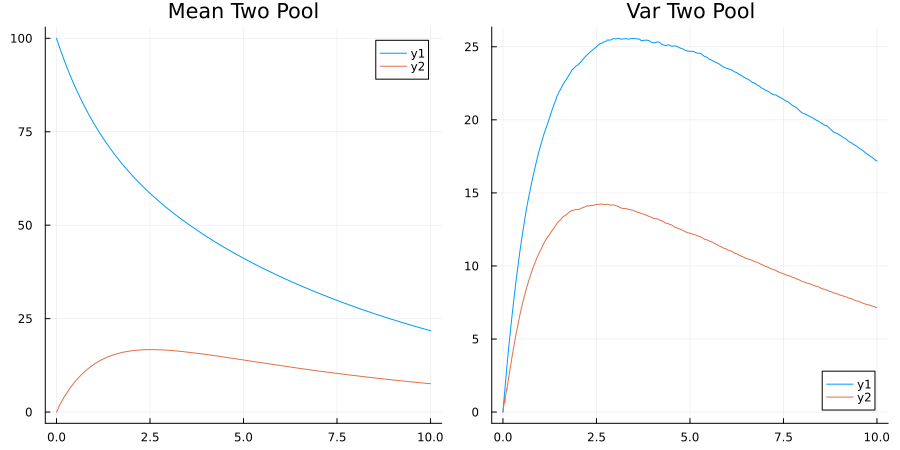

In [12]:
# plot ground truth
p_twopool_mean = plot(sol.u[1].t,truemean',title = "Mean Two Pool")
p_twopool_var = plot(sol.u[1].t,truevar', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

# Define NNs for Reaction Fluxes and Forward Simulate with SDE

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux ~/.julia/packages/DiffEqFlux/jHIee/src/fast_layers.jl:9


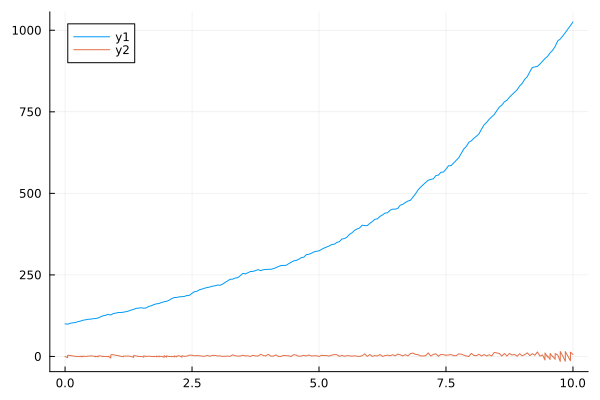

In [13]:
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,p)
    return [
        R4-(R1+R3),
        R3-(R2+R4)
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = sqrt.(ratesmodel(u,p))
    return [
        R1_r 0.0 -R3_r R4_r;
        0.0 R2_r R3_r R4_r
    ]
end

# NN: R^2 -> R^4, relu on final layer to force positive outputs
ratesmodel = FastChain(FastDense(2 , 16, relu), FastDense(16 , 4, relu));
p_nn = initial_params(ratesmodel);

prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    p_nn,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')

# Backprop with Neural SDE (keeps crashing Julia kernel............ ;P)

In [ ]:
function loss_neuralsde(p,u=u_0,N=100)
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT)
    ensembleprob = EnsembleProblem(prob)
    sol = solve(ensembleprob, EM(), dt = 0.05, saveat = 0.05; trajectories = N, sensealg=TrackerAdjoint(), save_everystep=false)
    batch_mean = mean(sol,dims=3)[:,:]
    batch_vars = var(sol,dims=3)[:,:]
    loss = sum(abs2, truemean .- batch_mean) + sum(abs2, p) + sum(abs2, truevar .- batch_vars)
end
test = Zygote.gradient(p->loss_neuralsde(p),p_nn)
# loss_neuralsde(p_nn,u_0)

In [62]:
# function getprediction(p,u=u_0)
#     prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
#     sol = solve(prob,EM(),dt = 0.05, saveat = 0.05; sensealg=TrackerAdjoint(), save_everystep=false)
#     #     if (sol.retcode != ReturnCode.Success)
# #         print(p)
# #     end
# #     println(sol)
#     return Array(sol)
# end

# function predict_batch_neuralsde(p, n)
#     res = map((x->getprediction(p,x)),[u_0 for i in 1:n])
#     VA = VectorOfArray(res)
#     arr = convert(Array,VA)
# end

# # function predictmeanvar(p,n)
# #     samples = predict_batch_neuralsde(p,n)
# #     means = mean(samples, dims = 3)
# #     vars = var(samples, dims = 3, mean = means)
# #     return means,vars
# # end

# # means,vars = predictmeanvar(p_nn,100)

# # function loss_neuralsde(p; n = 100)
# #     means,vars = predictmeanvar(p,n)
# #     testmeans = means[1,:,:]
# #     testvars = vars[1,:,:]
# #     println(testmeans)
    
# #     loss = sum(abs2, truemean[1,:] .- testmeans) + sum(abs2, p) + sum(abs2, truevar[1,:] .- testvars)
# #     return loss#, means, vars
# # end
# # test = Zygote.gradient(loss_neuralsde,p_nn)

2×401×100 Array{Float64, 3}:
[:, :, 1] =
 100.0  99.1238    99.1238    98.1586   …  37.0519  37.0519  37.7533  37.7533
   0.0   0.981125   0.981125   1.78829     65.9958  65.9958  66.1638  66.1638

[:, :, 2] =
 100.0  97.8024   97.8024   98.0568   …  34.9421  34.9421  34.2372  34.2372
   0.0   2.25819   2.25819   2.00241     62.8713  62.8713  62.9884  62.9884

[:, :, 3] =
 100.0  98.9307    98.9307    98.431   …  37.1044  37.1044  37.848   37.848
   0.0   0.987535   0.987535   1.2096     68.4151  68.4151  69.7095  69.7095

;;; … 

[:, :, 98] =
 100.0  98.4409   98.4409   96.0298  …  36.1167  36.1167  35.9315  35.9315
   0.0   1.83769   1.83769   4.23       59.3901  59.3901  60.0887  60.0887

[:, :, 99] =
 100.0  97.8161   97.8161   97.8761   …  34.0158  34.0158  33.2502  33.2502
   0.0   2.06701   2.06701   2.02516     62.0789  62.0789  60.9998  60.9998

[:, :, 100] =
 100.0  98.0774  98.0774  97.3404   …  33.478   33.478   33.7107  33.7107
   0.0   1.5425   1.5425   2.17298     57.758

In [113]:
opt = ADAM(0.0001)

# First round of training with n = 10
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p_nn)#Change to p_nn if first time running
result1 = Optimization.solve(optprob, opt, maxiters = 1000);

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(201), Base.OneTo(1)), b has dims (Base.OneTo(401),), mismatch at 1")